# MODULOS

In [2]:
!pip install cartopy #instalacion de paquetes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 18.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib import gridspec
from cartopy import crs,feature
from scipy import stats
from sklearn.decomposition import PCA

Mounted at /content/drive


# PATHS

In [4]:
path_datos = '/content/drive/MyDrive/2025-S1/Monitoria_ada/datos/'

# FUNCIONES

In [5]:
def apply_fft(y):
    fourier = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y))
    periodo = 1/freq
    potencia = np.abs(fourier)**2
    return (fourier, freq, periodo, potencia)
def apply_ifft(fourier):
    inversa = np.fft.ifft(fourier)
    return inversa

# DATOS

In [20]:
#!wget https://downloads.psl.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc
olr_data = xr.open_dataset(path_datos+'olr.day.mean.nc',decode_times=True) # https://downloads.psl.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc

In [7]:
print("Minimo:", olr_data.olr.min().values)
print("Minimo:", olr_data.olr.max().values)

Minimo: 64.75
Minimo: 344.5


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


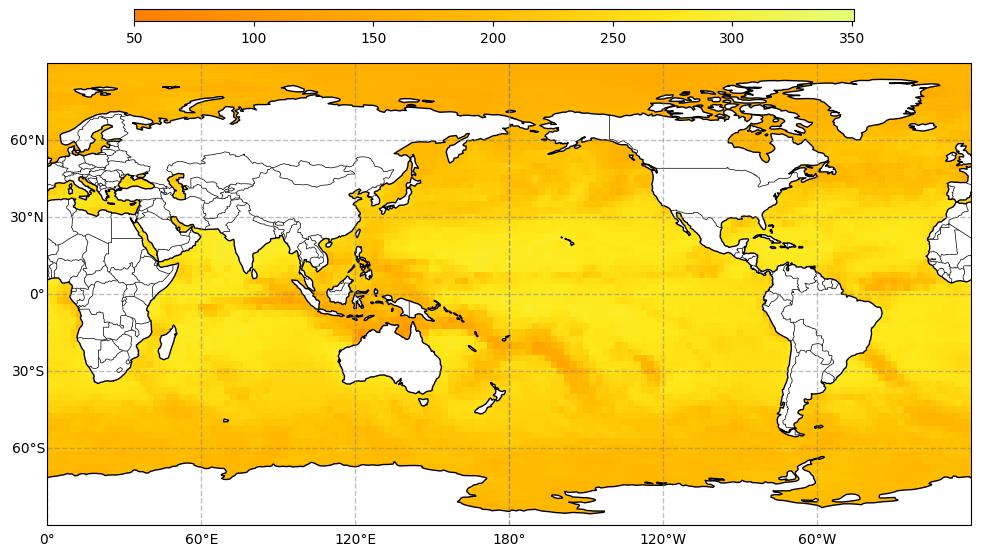

In [8]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111,projection=crs.PlateCarree(central_longitude=180))
cax = fig.add_axes([0.2, 0.95, 0.6, 0.02]) #axis barra de color

gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Agregar los datos
mesh = ax.pcolormesh(
    olr_data.lon, olr_data.lat,
    olr_data.olr[-1],
    cmap='Wistia_r',
    vmin=50, vmax=351,
    transform=crs.PlateCarree())

ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5)
ax.add_feature(feature.LAND, facecolor='white',zorder=1)
cbar = plt.colorbar(mesh, cax=cax, orientation='horizontal')

## Ciclo Anual

In [21]:
olr_ca = olr_data.groupby('time.month').mean('time')

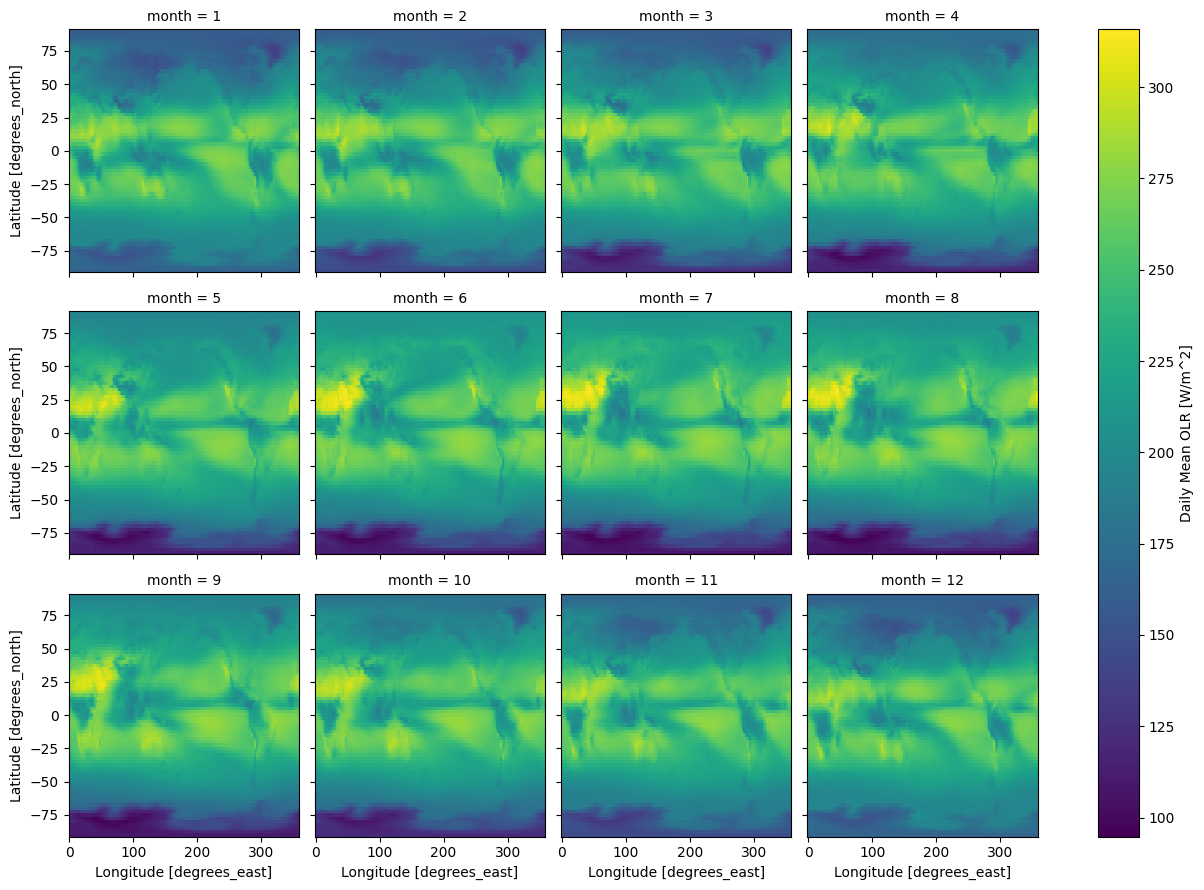

In [22]:
olr_ca.olr.plot(x="lon", y="lat", col="month", col_wrap=4)

# TRANSFORMADA DE FOURIER

In [23]:
olr_tropical = olr_data.sel(lat=slice(25,-25)).dropna('time')
olr_tropical_nomean = olr_tropical - olr_data.mean()

In [24]:
fft_result = xr.apply_ufunc(
    apply_fft,
    olr_tropical_nomean.olr,
    input_core_dims=[['time']],
    output_core_dims=[['n'],['n'],['n'],['n']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[complex, np.float32, np.float32, np.float32])

<ipython-input-5-836274910>:4: RuntimeWarning: divide by zero encountered in divide
  periodo = 1/freq


In [25]:
olr_fft, freq_olr, periodo_olr, potencia_olr = fft_result

In [40]:
olr_filtered = olr_fft.where((freq_olr > 1/90) & (freq_olr < 1/25),0)

In [41]:
olr_filter_reconstruct = xr.apply_ufunc(
    apply_ifft,
    olr_filtered,
    input_core_dims=[['n']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float32]
)


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2531: ComplexWarning: Casting complex values to real discards the imaginary part
  output[index] = result


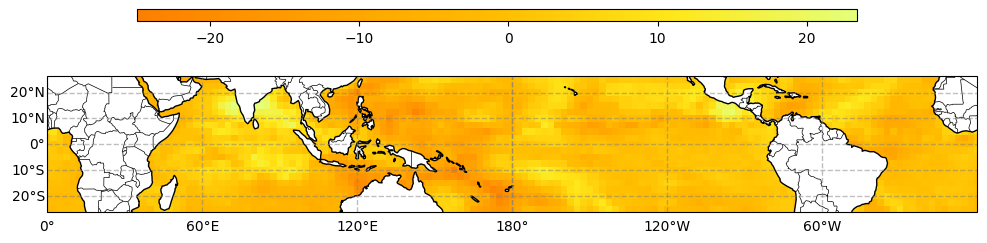

In [42]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111,projection=crs.PlateCarree(central_longitude=180))
cax = fig.add_axes([0.2, 0.7, 0.6, 0.02]) #axis barra de color

gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Agregar los datos
mesh = ax.pcolormesh(
    olr_filter_reconstruct.lon, olr_filter_reconstruct.lat,
    olr_filter_reconstruct.real[:,:,-1],
    cmap='Wistia_r',
    #vmin=50, vmax=351,
    transform=crs.PlateCarree())

ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5)
ax.add_feature(feature.LAND, facecolor='white',zorder=1)
cbar = plt.colorbar(mesh, cax=cax, orientation='horizontal')

# PCA

In [43]:
olr_tropical.time

<xarray.DataArray 'time' (time: 17456)> Size: 140kB
array(['1974-06-01T00:00:00.000000000', '1974-06-02T00:00:00.000000000',
       '1974-06-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 140kB 1974-06-01 1974-06-02 ... 2022-12-31
Attributes:
    long_name:      Time
    delta_t:        0000-00-01 00:00:00
    standard_name:  time
    axis:           T
    actual_range:   [1528872. 1954752.]

In [46]:
olr_filter_reconstruct = olr_filter_reconstruct.assign_coords(time=olr_tropical.time)
olr_filter_reconstruct.time

<xarray.DataArray 'time' (time: 17456)> Size: 140kB
array(['1974-06-01T00:00:00.000000000', '1974-06-02T00:00:00.000000000',
       '1974-06-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 140kB 1974-06-01 1974-06-02 ... 2022-12-31
Attributes:
    long_name:      Time
    delta_t:        0000-00-01 00:00:00
    standard_name:  time
    axis:           T
    actual_range:   [1528872. 1954752.]

In [47]:
# Verano Norte - Boreal
summer_olr = olr_filter_reconstruct.sel(time=olr_filter_reconstruct.time.dt.month.isin([5,6,7,8]))

In [48]:
X = summer_olr.stack(grid=['lat','lon'])

In [49]:
X # PODEMOS JUZAGAR CON LA MAGNITUD, IMPORTANCIA
# MODO 3 CONEXION MONSON INDICO MADEN JULIA PACIFICO (TELECONEXION)
# MODO 1 MODO 2, DESPAZAMIENTO?
# SON ORTOGONALES SOLO EN TIEMPO CERO
# CORRELACIONADOS CON REZAGO
# PROPAGACION
# correlacion rezagada movimiento de 10 dias
# 11,12,1,2 definicion en invierno
# alterar la magnitud de los vientos alicios
# la superfcia del mar aumentan se profundiza la termoclina, ondas kelvin
# maden julian tiene la capacidad de empezar un ENSO

<xarray.DataArray 'olr' (time: 5873, grid: 3024)> Size: 71MB
array([[-8.000617  , -3.6148224 , -3.3255277 , ...,  0.37731424,
        -1.0196947 , -1.1728944 ],
       [-7.746487  , -3.6197436 , -3.5294    , ...,  0.21959938,
        -1.1208986 , -1.187726  ],
       [-7.2501726 , -3.4546666 , -3.5688522 , ...,  0.03189348,
        -1.1838311 , -1.1585721 ],
       ...,
       [-3.9429314 , -4.4269986 , -0.15477632, ...,  3.0958254 ,
         3.5340874 ,  2.7154582 ],
       [-3.4165332 , -4.129232  , -0.22478493, ...,  3.273056  ,
         3.731123  ,  2.7024868 ],
       [-2.6926975 , -3.6813455 , -0.19076966, ...,  3.41957   ,
         3.8644297 ,  2.6618068 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 47kB 1974-06-01 1974-06-02 ... 2022-08-31
  * grid     (grid) object 24kB MultiIndex
  * lat      (grid) float32 12kB 25.0 25.0 25.0 25.0 ... -25.0 -25.0 -25.0 -25.0
  * lon      (grid) float32 12kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5

In [50]:
X_mean = np.mean(X,axis=0)
X_std = np.std(X,axis=0)
X_std[X_std==0] = 1
X_norm = (X-X_mean)/X_std # TODOS LOS PIXELES IMPORTAN LO MISMO (DETECTAR ESTRUCTURA ESPACIAL,CONEXIÓN ENTRE COLORES, NO IMPORTANCIA DE LA INTESIDAD DEL COLOR)

In [ ]:
pca = PCA()
pca.fit(X_norm)
eigen_values =